In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn
import numpy as np

To address an interesting and practical case (entanglement doesn't grow too much) we'll use as
an initial state the all zero state apart from two flipped spins:

In [2]:
L = 44
zeros = '0' * ((L - 2) // 3)
binary = zeros + '1' + zeros + '1' + zeros
print('psi0:', "|{}>".format(binary))

psi0: |00000000000000100000000000000100000000000000>


In [3]:
psi0 = qtn.MPS_computational_state(binary)
psi0.show()  # prints ascii representation of state

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
>->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-<
| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |


To set the hamiltonian, we just need to define the effective two-site interaction hamiltonian.
For the Heisenberg hamiltonian with no magnetic field, this is just the following:

In [4]:
H_int = qu.ham_heis(n=2, cyclic=False)
H_int

matrix([[ 0.25,  0.  ,  0.  ,  0.  ],
        [ 0.  , -0.25,  0.5 ,  0.  ],
        [ 0.  ,  0.5 , -0.25,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.25]])

In [5]:
tebd = qtn.TEBD(psi0, H_int)

# Since entanglement will not grow too much, we can set quite
#     a small cutoff for splitting after each gate application
tebd.split_opts['cutoff'] = 1e-14

We'll also set up some parameters and quantities to compute during the evolution:

In [6]:
# times we are interested in
ts = np.linspace(0, 80, 101)

mz_t_j = []  # z-magnetization
be_t_b = []  # block entropy
sg_t_b = []  # schmidt gap

# range of bonds, and sites
js = np.arange(0, L)
bs = np.arange(1, L)

Now we are ready to being the evolution, we use the generator 
``at_times`` to yield the state at each target time, and set
a ``tol`` here which will calculate a timestep to use.
At each time, we'll compute the desired quantities and add them
to our results.

In [7]:
# generate the state at each time in ts
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(ts, tol=1e-3):
    mz_j = []
    be_b = []
    sg_b = []
    
    # there is one more site than bond, so start with mag
    #     this also sets the orthog center to 0
    mz_j += [psit.magnetization(0)]
    
    for j in range(1, L):
        # after which we only need to move it from previous site
        mz_j += [psit.magnetization(j, current_orthog_centre=j - 1)]
        be_b += [psit.entropy(j, current_orthog_centre=j)]
        sg_b += [psit.schmidt_gap(j, current_orthog_centre=j)]
        
    mz_t_j += [mz_j]
    be_t_b += [be_b]
    sg_t_b += [sg_b]

t=80, max-bond=19: 100%|██████████| 101/101 [02:23<00:00,  1.42s/it]  


In [8]:
tebd.pt.show()

 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17 17 18 18 18 18 18 19 18 18 18 18 18 17 17 16 15 14 13 12 11 10 9 8 7 6 5 4 2 
>->->->->->->->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->->->->->->->-o
| | | | | | | |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | | | | | | | |


``TEBD.err`` contains a (rough) upper estimate for the error 
incurred by the trotter decomposition so far:

In [9]:
tebd.err  #  should be < tol=1e-3

0.0009938931328611381

We can also check the normalization of final state:

In [10]:
tebd.pt.H @ tebd.pt

1.0000000000233802

And that energy has been conserved:

In [11]:
H = qtn.MPO_ham_heis(L)
print("Initial energy:", qtn.expec_TN_1D(psi0.H, H, psi0))
print("Final energy:", qtn.expec_TN_1D(tebd.pt.H , H, tebd.pt))

Initial energy: 8.75
Final energy: 8.750002302548694


Finally let's plot the quantities we calculated:

In [12]:
import matplotlib.pyplot as plt

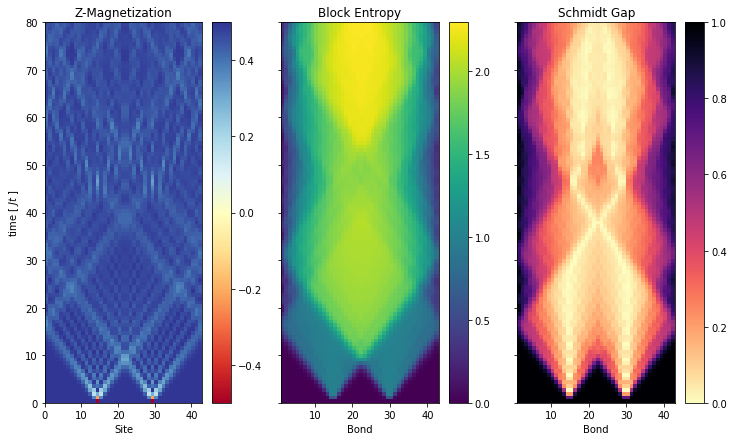

In [13]:
plt.figure(figsize=(12, 7))

# plot the magnetization
ax1 = plt.subplot('131')
plt.pcolormesh(js, ts, mz_t_j, vmin=-0.5, vmax=0.5)
plt.set_cmap('RdYlBu')
plt.colorbar()
plt.title('Z-Magnetization')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

# plot the entropy
ax2 = plt.subplot('132', sharey=ax1)
plt.pcolormesh(bs, ts, be_t_b)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.set_cmap('viridis'), plt.colorbar()
plt.title('Block Entropy')
plt.xlabel('Bond')

# plot the schmidt gap
ax3 = plt.subplot('133', sharey=ax1)
plt.pcolormesh(bs, ts, sg_t_b, vmin=0, vmax=1)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.set_cmap('magma_r')
plt.colorbar()
plt.title('Schmidt Gap')
plt.xlabel('Bond')

plt.show()

Where we can see ballistic propagation (and reflection) of the 'light cone'.